# Understanding decreased drug attrition for NPs based on toxicity data

In [1]:
import os
import warnings

import pandas as pd
from rdkit import RDLogger
from rdkit.Contrib.NP_Score import npscorer
from rdkit import Chem
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from statannotations.Annotator import Annotator

In [2]:
# Disable warnings
RDLogger.DisableLog("rdApp.*")
warnings.filterwarnings("ignore", "is_categorical_dtype")

# Functions

In [3]:
def get_percent_distributions(scores: list) -> dict:
    """Get the percentage distribution of the classes"""
    hybrid_percentage = round(
        len([score for score in scores if score >= 0 and score <= 0.6])
        / len(scores)
        * 100,
        2,
    )

    np_like_percentage = round(
        len([score for score in scores if score > 0.6]) / len(scores) * 100, 2
    )

    synthetics_percentage = round(
        len([score for score in scores if score < 0]) / len(scores) * 100, 2
    )

    assert sum([np_like_percentage, synthetics_percentage, hybrid_percentage]) > 99

    assert sum([np_like_percentage, synthetics_percentage, hybrid_percentage]) < 101

    return {
        "hybrid_percentage": hybrid_percentage,
        "np_like_percentage": np_like_percentage,
        "synthetics_percentage": synthetics_percentage,
    }

# Load carcinogenic data

In [4]:
carcinogenic_df = pd.read_csv("../../data/Carcinogenicity.csv")
carcinogenic_df.head(2)

,TAID,Name,IUPAC Name,PubChem CID,Canonical SMILES,InChIKey,Toxicity Value
0,TOX-19,mannitol,"(2R,3R,4R,5R)-hexane-1,2,3,4,5,6-hexol",6251.0,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,FBPFZTCFMRRESA-KVTDHHQDSA-N,0
1,TOX-28,nitroglycerin,"1,3-dinitrooxypropan-2-yl nitrate",4510.0,O=[N+]([O-])OCC(CO[N+](=O)[O-])O[N+](=O)[O-],SNIOPGDIGTZGOP-UHFFFAOYSA-N,1


In [5]:
carcinogenic_df.dropna(subset=["Canonical SMILES"], inplace=True)
carcinogenic_df.drop_duplicates(subset=["Canonical SMILES"], inplace=True)

In [6]:
cmp_smiles = carcinogenic_df["Canonical SMILES"].tolist()
f"Carcinogenic compounds: {len(cmp_smiles)}"

'Carcinogenic compounds: 1001'

In [7]:
carcinogenic_df["Toxicity Value"].value_counts()

1    502
0    499
Name: Toxicity Value, dtype: int64

# NP likeliness

In [8]:
np_model = npscorer.readNPModel()

reading NP model ...
model in


In [9]:
np_scores = []
skipped = 0

for input_smile in tqdm(cmp_smiles):
    # get mol
    try:
        input_smile = Chem.CanonSmiles(input_smile)
        mol = Chem.MolFromSmiles(input_smile)
    except:
        skipped += 1
        np_scores.append(None)
        continue

    if mol is None:
        skipped += 1
        np_scores.append(None)
        continue

    # if number of atoms less than 4, skip
    if mol.GetNumAtoms() < 4:
        skipped += 1
        np_scores.append(None)
        continue

    # get score
    try:
        score = npscorer.scoreMol(mol, np_model)
    except:
        skipped += 1
        np_scores.append(None)
        continue

    np_scores.append(score)

f"Skipped {skipped} compounds"

100%|██████████| 1001/1001 [00:00<00:00, 3350.13it/s]


'Skipped 1 compounds'

In [10]:
carcinogenic_df["np_score"] = np_scores
carcinogenic_df.dropna(subset=["np_score"], inplace=True)

In [11]:
toxic_carcinogen = carcinogenic_df[carcinogenic_df["Toxicity Value"] == 1]
non_toxic_carcinogen = carcinogenic_df[carcinogenic_df["Toxicity Value"] == 0]

In [12]:
percent_tox_carcino_dict = get_percent_distributions(
    toxic_carcinogen["np_score"].tolist()
)
percent_non_tox_carcino_dict = get_percent_distributions(
    non_toxic_carcinogen["np_score"].tolist()
)

# CYP450

In [13]:
DATA_PATH = "../../data/CYP450/"

cyp_data = []
for file in os.listdir(DATA_PATH):
    if file.endswith(".csv"):
        cyp_data.append(pd.read_csv(f"{DATA_PATH}{file}"))

cyp_df = pd.concat(cyp_data)
cyp_df.head(2)

,TAID,Name,IUPAC Name,PubChem CID,Canonical SMILES,InChIKey,Toxicity Value
0,TOX-75,minoxidil,3-hydroxy-2-imino-6-piperidin-1-ylpyrimidin-4-...,4201.0,Nc1cc(N2CCCCC2)nc(N)[n+]1[O-],ZIMGGGWCDYVHOY-UHFFFAOYSA-N,0
1,TOX-90,dichlorphenamide,"4,5-dichlorobenzene-1,3-disulfonamide",3038.0,NS(=O)(=O)c1cc(Cl)c(Cl)c(S(N)(=O)=O)c1,GJQPMPFPNINLKP-UHFFFAOYSA-N,0


In [14]:
cyp_df.dropna(subset=["Canonical SMILES"], inplace=True)
cyp_df.drop_duplicates(subset=["Canonical SMILES"], inplace=True)

In [15]:
cyp450_cmp_smiles = cyp_df["Canonical SMILES"].tolist()
f"CYP450 compounds: {len(cyp450_cmp_smiles)}"

'CYP450 compounds: 16234'

In [16]:
cyp_df["Toxicity Value"].value_counts()

0    10489
1     5745
Name: Toxicity Value, dtype: int64

# NP likeliness

In [17]:
np_scores = []
skipped = 0

for input_smile in tqdm(cyp450_cmp_smiles):
    # get mol
    try:
        input_smile = Chem.CanonSmiles(input_smile)
        mol = Chem.MolFromSmiles(input_smile)
    except:
        skipped += 1
        np_scores.append(None)
        continue

    if mol is None:
        skipped += 1
        np_scores.append(None)
        continue

    # if number of atoms less than 4, skip
    if mol.GetNumAtoms() < 4:
        skipped += 1
        np_scores.append(None)
        continue

    # get score
    try:
        score = npscorer.scoreMol(mol, np_model)
    except:
        skipped += 1
        np_scores.append(None)
        continue

    np_scores.append(score)

f"Skipped {skipped} compounds"

  0%|          | 0/16234 [00:00<?, ?it/s]

100%|██████████| 16234/16234 [00:05<00:00, 3108.75it/s]


'Skipped 1 compounds'

In [18]:
cyp_df["np_score"] = np_scores
cyp_df.dropna(subset=["np_score"], inplace=True)

In [19]:
toxic_cyp450 = cyp_df[cyp_df["Toxicity Value"] == 1]
non_toxic_cyp450 = cyp_df[cyp_df["Toxicity Value"] == 0]

In [20]:
percent_tox_cyp450_dict = get_percent_distributions(toxic_cyp450["np_score"].tolist())
percent_non_tox_cyp450_dict = get_percent_distributions(
    non_toxic_cyp450["np_score"].tolist()
)

# Heptatoxicity

In [21]:
hepato_df = pd.read_csv("../../data/Hepatotoxicity.csv")
hepato_df.head(2)

,TAID,Name,IUPAC Name,PubChem CID,Canonical SMILES,InChIKey,Toxicity Value
0,TOX-9,ethinamate,(1-ethynylcyclohexyl) carbamate,3284.0,C#CC1(OC(N)=O)CCCCC1,GXRZIMHKGDIBEW-UHFFFAOYSA-N,0
1,TOX-21,D-Sorbitol,"(2R,3R,4R,5S)-hexane-1,2,3,4,5,6-hexol",5780.0,OC[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,FBPFZTCFMRRESA-JGWLITMVSA-N,0


In [22]:
hepato_df.dropna(subset=["Canonical SMILES"], inplace=True)
hepato_df.drop_duplicates(subset=["Canonical SMILES"], inplace=True)

In [23]:
hepato_cmp_smiles = hepato_df["Canonical SMILES"].tolist()
f"Hepatotoxicity compounds: {len(hepato_cmp_smiles)}"

'Hepatotoxicity compounds: 2847'

In [24]:
hepato_df["Toxicity Value"].value_counts()

1    1450
0    1397
Name: Toxicity Value, dtype: int64

# NP likeliness

In [25]:
np_scores = []
skipped = 0

for input_smile in tqdm(hepato_cmp_smiles):
    # get mol
    try:
        input_smile = Chem.CanonSmiles(input_smile)
        mol = Chem.MolFromSmiles(input_smile)
    except:
        skipped += 1
        np_scores.append(None)
        continue

    if mol is None:
        skipped += 1
        np_scores.append(None)
        continue

    # if number of atoms less than 4, skip
    if mol.GetNumAtoms() < 4:
        skipped += 1
        np_scores.append(None)
        continue

    # get score
    try:
        score = npscorer.scoreMol(mol, np_model)
    except:
        skipped += 1
        np_scores.append(None)
        continue

    np_scores.append(score)

f"Skipped {skipped} compounds"

100%|██████████| 2847/2847 [00:00<00:00, 2850.37it/s]


'Skipped 6 compounds'

In [26]:
hepato_df["np_score"] = np_scores
hepato_df.dropna(subset=["np_score"], inplace=True)

In [27]:
toxic_hepato = hepato_df[hepato_df["Toxicity Value"] == 1]
non_toxic_hepato = hepato_df[hepato_df["Toxicity Value"] == 0]

In [28]:
percent_tox_hepato_dict = get_percent_distributions(toxic_hepato["np_score"].tolist())
percent_non_tox_hepato_dict = get_percent_distributions(
    non_toxic_hepato["np_score"].tolist()
)

# Distribution plot

In [29]:
# create a dataframe with the data
percentages_df = pd.DataFrame(
    [
        percent_tox_carcino_dict,
        percent_non_tox_carcino_dict,
        percent_tox_cyp450_dict,
        percent_non_tox_cyp450_dict,
        percent_tox_hepato_dict,
        percent_non_tox_hepato_dict,
    ],
    index=[
        "Caricinogens",
        "Non-Carcinogens",
        "CYP450 Toxicity",
        "CYP450 Non-Toxicity",
        "Hepatotoxicity",
        "Hepatotoxicity Non-Toxicity",
    ],
)

In [30]:
# rename percentage columns
percentages_df = percentages_df.rename(
    columns={
        "hybrid_percentage": "Hybrid",
        "n_hybrid": "Hybrid Count",
        "np_like_percentage": "NP",
        "n_np_like": "NP Count",
        "synthetics_percentage": "Synthetic",
        "n_synthetics": "Synthetic Count",
    }
)
percentages_df

,Hybrid,NP,Synthetic
Caricinogens,18.92,14.94,66.14
Non-Carcinogens,19.48,22.29,58.23
CYP450 Toxicity,4.72,5.24,90.04
CYP450 Non-Toxicity,12.43,17.18,70.39
Hepatotoxicity,13.19,32.67,54.14
Hepatotoxicity Non-Toxicity,14.36,57.00,28.64


In [31]:
def prep_df_with_plot(df):
    """Prepare the dataframe with plot"""

    df_list = []

    for idx, row in df.iterrows():
        (
            hybrid_percentage,
            np_like_percentage,
            synthetics_percentage,
        ) = row.values

        if idx == "Caricinogens":
            idx = "Carcinogens"

        tmp = pd.DataFrame(
            [
                ["Hybrid", idx, hybrid_percentage],
                ["NP", idx, np_like_percentage],
                ["Synthetic", idx, synthetics_percentage],
            ],
            columns=["Class", "Tox", "Percentage"],
        )

        df_list.append(tmp)

    return pd.concat(df_list)

In [32]:
bar_plot = prep_df_with_plot(percentages_df)

In [33]:
car = bar_plot[bar_plot["Tox"].isin(["Carcinogens", "Non-Carcinogens"])]
hep = bar_plot[bar_plot["Tox"].isin(["Hepatotoxicity", "Hepatotoxicity Non-Toxicity"])]
cyp = bar_plot[bar_plot["Tox"].isin(["CYP450 Toxicity", "CYP450 Non-Toxicity"])]

## chi-squared test

In [34]:
from scipy.stats import chi2_contingency, contingency

In [35]:
# contingency table for carcinogenicity
carcino_contingency_table = [
    [
        percent_tox_carcino_dict["np_like_percentage"],
        percent_tox_carcino_dict["synthetics_percentage"],
    ],
    [
        percent_non_tox_carcino_dict["np_like_percentage"],
        percent_non_tox_carcino_dict["synthetics_percentage"],
    ],
]
carcino_res = chi2_contingency(carcino_contingency_table)

# contingency table for carcinogenicity
hepato_contingency_table = [
    [
        percent_tox_hepato_dict["np_like_percentage"],
        percent_tox_hepato_dict["synthetics_percentage"],
    ],
    [
        percent_non_tox_hepato_dict["np_like_percentage"],
        percent_non_tox_hepato_dict["synthetics_percentage"],
    ],
]

# Null hypothesis: NP-like and synthetic compounds are equally likely to be hepatotoxic
hepato_res = chi2_contingency(hepato_contingency_table)

# contingency table for carcinogenicity
cyp_contingency_table = [
    [
        percent_tox_cyp450_dict["np_like_percentage"],
        percent_tox_cyp450_dict["synthetics_percentage"],
    ],
    [
        percent_non_tox_cyp450_dict["np_like_percentage"],
        percent_non_tox_cyp450_dict["synthetics_percentage"],
    ],
]

# Null hypothesis: NP-like and synthetic compounds are equally likely to be CYP450 toxic
cyp_res = chi2_contingency(cyp_contingency_table)

In [36]:
sns.set_style("whitegrid")

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NP vs. Synthetic: Custom statistical test, P_val:2.261e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NP vs. Synthetic: Custom statistical test, P_val:2.635e-04
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NP vs. Synthetic: Custom statistical test, P_val:7.315e-03


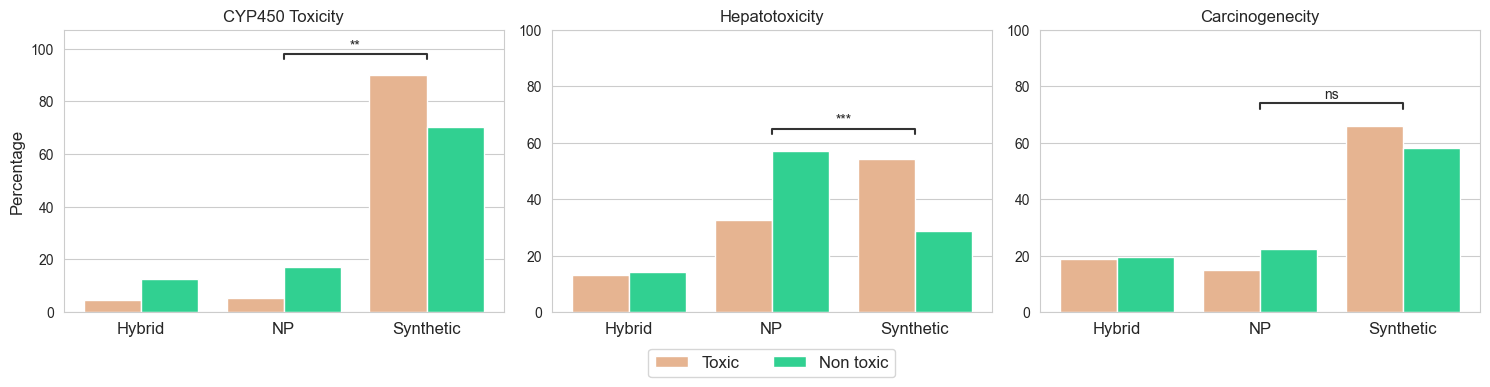

In [37]:
plt.figure(figsize=([15, 4]))

order_list = ["Hybrid", "NP", "Synthetic"]

plt.subplot(1, 3, 3)
ax1 = sns.barplot(
    data=car,
    x="Class",
    y="Percentage",
    hue="Tox",
    order=order_list,
    hue_order=["Carcinogens", "Non-Carcinogens"],
    palette=["#F4B183", "#16EB96"],
    alpha=1,
)

ax1.get_legend().remove()
plt.title("Carcinogenecity", fontsize=12)
plt.ylabel("")
plt.xticks(fontsize=12)
plt.xlabel("")

ax1.set_ylim([0, 100])

# Add annotations
annotator = Annotator(
    ax1,
    data=car,
    x="Class",
    y="Percentage",
    pairs=[("NP", "Synthetic")],
)
annotator.set_pvalues([carcino_res.pvalue])
annotator.annotate()

plt.subplot(1, 3, 2)
ax2 = sns.barplot(
    data=hep,
    x="Class",
    y="Percentage",
    hue="Tox",
    order=["Hybrid", "NP", "Synthetic"],
    hue_order=["Hepatotoxicity", "Hepatotoxicity Non-Toxicity"],
    palette=["#F4B183", "#16EB96"],
    alpha=1,
)
ax2.get_legend().remove()
plt.title("Hepatotoxicity", fontsize=12)
plt.ylabel("")
plt.xticks(fontsize=12)
plt.xlabel("")
ax2.set_ylim([0, 100])

# Add annotations
annotator = Annotator(
    ax2,
    data=hep,
    x="Class",
    y="Percentage",
    pairs=[("NP", "Synthetic")],
)
annotator.set_pvalues([hepato_res.pvalue])
annotator.annotate()

plt.subplot(1, 3, 1)
ax3 = sns.barplot(
    data=cyp,
    x="Class",
    y="Percentage",
    hue="Tox",
    order=["Hybrid", "NP", "Synthetic"],
    hue_order=["CYP450 Toxicity", "CYP450 Non-Toxicity"],
    palette=["#F4B183", "#16EB96"],
    alpha=1,
)
ax3.get_legend().remove()
plt.title("CYP450 Toxicity", fontsize=12)
plt.ylabel("")
plt.xticks(fontsize=12)
plt.xlabel("")
ax3.set_ylim([0, 100])
plt.ylabel("Percentage", fontsize=12)

# Add annotations
annotator = Annotator(
    ax3,
    data=cyp,
    x="Class",
    y="Percentage",
    pairs=[("NP", "Synthetic")],
)
annotator.set_pvalues([cyp_res.pvalue])
annotator.annotate()

# add legend to ax2
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(
    handles,
    ["Toxic", "Non toxic"],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=2,
    # increase font size
    prop={"size": 12},
)

plt.tight_layout()

# dpi
plt.savefig("../../data/output/plots/figure4.png", dpi=500)
plt.show()

### Statistical significance through odds-ratio

In [38]:
carcino_contingency_table2 = [
    [
        round(percent_tox_carcino_dict["np_like_percentage"]),
        round(percent_tox_carcino_dict["synthetics_percentage"]),
    ],
    [
        round(percent_non_tox_carcino_dict["np_like_percentage"]),
        round(percent_non_tox_carcino_dict["synthetics_percentage"]),
    ],
]
res = contingency.odds_ratio(carcino_contingency_table2)
res.confidence_interval(confidence_level=0.95)

ConfidenceInterval(low=0.26319301780488685, high=1.3421628755633825)

In [39]:
hepato_contingency_table2 = [
    [
        round(percent_tox_hepato_dict["np_like_percentage"]),
        round(percent_tox_hepato_dict["synthetics_percentage"]),
    ],
    [
        round(percent_non_tox_hepato_dict["np_like_percentage"]),
        round(percent_non_tox_hepato_dict["synthetics_percentage"]),
    ],
]
res = contingency.odds_ratio(hepato_contingency_table2)
res.confidence_interval(confidence_level=0.95)

ConfidenceInterval(low=0.158961362665341, high=0.6059218456326446)

In [40]:
cyp_contingency_table2 = [
    [
        round(percent_tox_cyp450_dict["np_like_percentage"]),
        round(percent_tox_cyp450_dict["synthetics_percentage"]),
    ],
    [
        round(percent_non_tox_cyp450_dict["np_like_percentage"]),
        round(percent_non_tox_cyp450_dict["synthetics_percentage"]),
    ],
]
res = contingency.odds_ratio(cyp_contingency_table2)
res.confidence_interval(confidence_level=0.95)

ConfidenceInterval(low=0.06334511320671765, high=0.6920633630496894)